## Check individual items

#### The step after EDA

#### Dataset description:
The cleaned dataset contain data from July to Sep

### Rule:
There are three rules: see below.

#### Next step: 
**Inventory Segmentation within each calss**:  (since Different items have different price, sale qty and margin rate, therefore, we should consider different weight for different group) 

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
import warnings
from scipy import stats
import pyspark
import pandas
from Inventory_opti_helperFunction import *
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
import findspark
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
# Import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
import re

findspark.init()

"""
Build the SparkSession
"""
# getOrCreate(): get the current Spark session or to create one if there is none running
spark = SparkSession.builder \
   .master("local") \
   .appName("Linear Regression Model") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext # create a SparkSession object from your SparkContext

# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)

<SparkContext master=local appName=Linear Regression Model>
2.4.4


In [3]:
df = spark.read.csv("../data/CleanedData/month_merge_total.csv", header=True)

In [4]:
# clean data
# Conver columns to `FloatType()`
names = ["totalMonthlyNetSale", "totalMonthlyQtySold", "Price", "SellMargin", "Facings", "Capacity"]
df = convertColumn(df, names, FloatType())


In [5]:
## Summary Statistics
# This will give a quick glimpse to data, if columns are not mentioned all the numeric columns stats are produced 
columns_to_analyze=['Facings','Capacity','totalMonthlyQtySold','SellMargin']
df.select(*[columns_to_analyze]).describe().show()

+-------+-----------------+------------------+-------------------+------------------+
|summary|          Facings|          Capacity|totalMonthlyQtySold|        SellMargin|
+-------+-----------------+------------------+-------------------+------------------+
|  count|             1516|              1516|               1516|              1516|
|   mean|4.934036939313984|17.201846965699207|   46.3509234828496|1590.5408112757439|
| stddev|4.839292129312515|19.178753281810355| 127.39453881779538|3325.4021179841084|
|    min|              1.0|               1.0|                1.0|           -269.64|
|    max|             44.0|             202.0|             1932.0|         53821.047|
+-------+-----------------+------------------+-------------------+------------------+



In [6]:
pdf = df.toPandas() # creat panda object for ploting

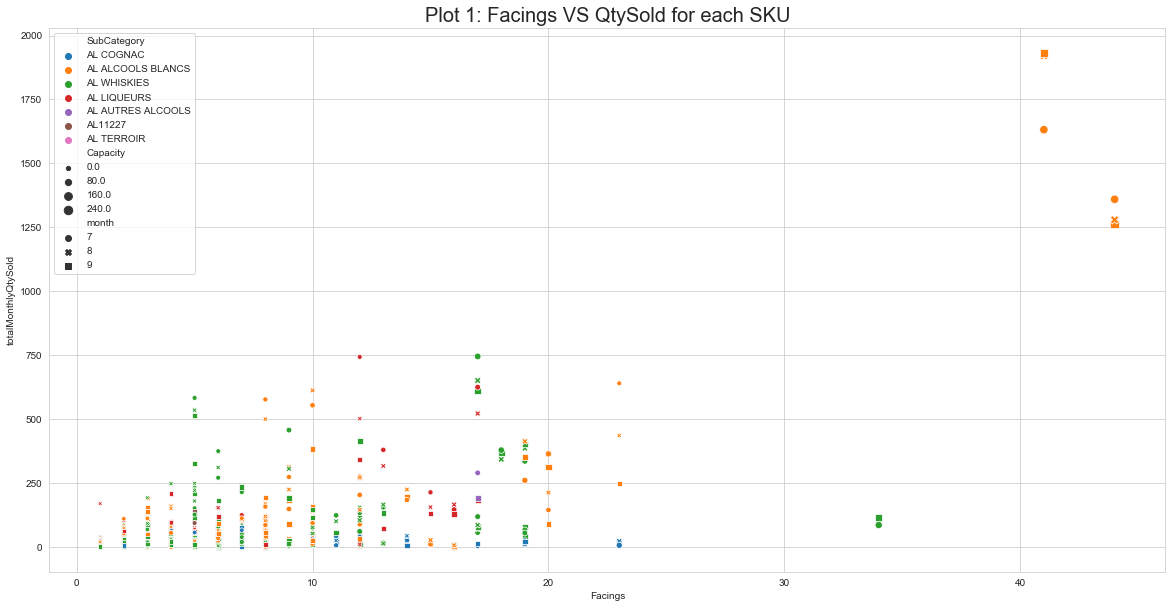

In [7]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="Facings", y="totalMonthlyQtySold", hue = "SubCategory", style = 'month',
                     size = 'Capacity', data=pdf)
ax.set_title("Plot 1: Facings VS QtySold for each SKU", fontsize=20)
plt.show()

Explain the difference between Average and Total

SKU1 | Cat1 | Month1 |5
SKU1 | Cat1 | Month2 |6
SKU2 | Cat1 | Month1 |3
SKU3 | Cat1 | Month1 |7

Total of 'Cat1' is 5+6+7+3 = 21
Average of 'Cat1' is (5+6+7+3)/4 = 5.25

Plot for totalMonthlyQtySold


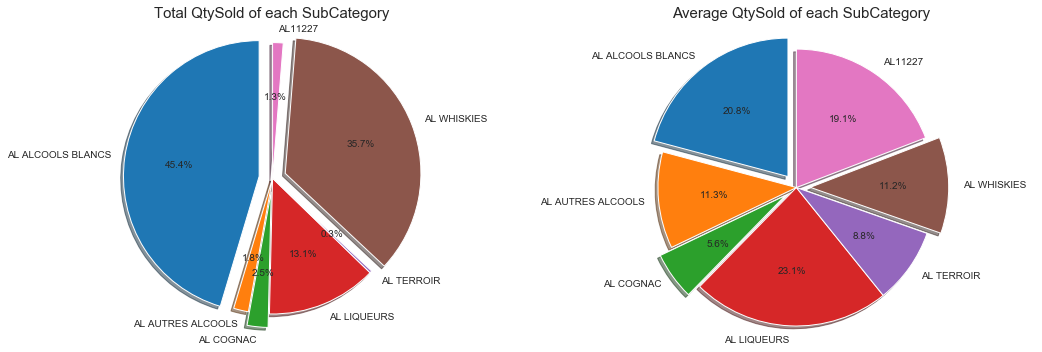

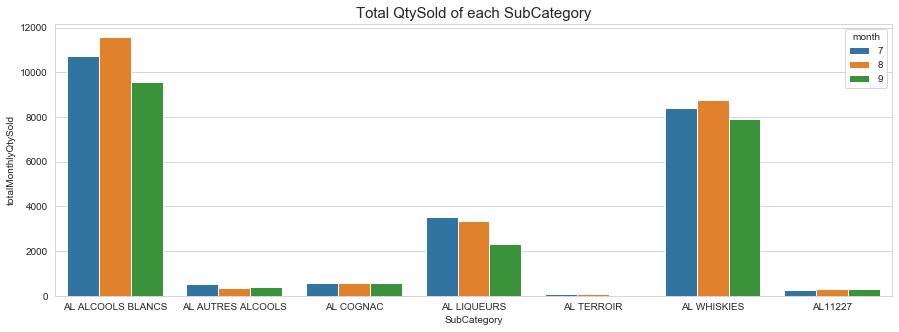

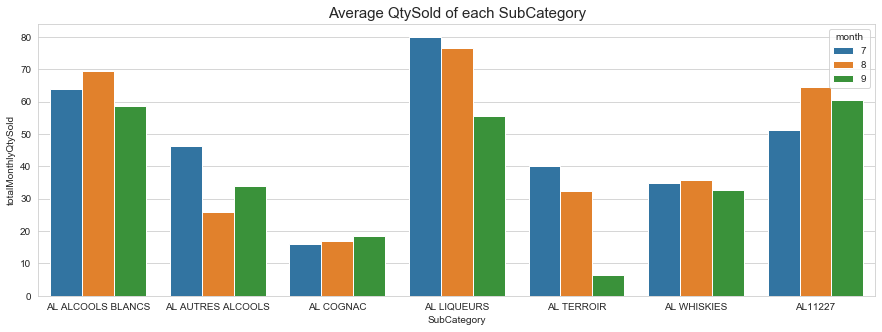


------------------------------------------------------------------
Plot for Capacity


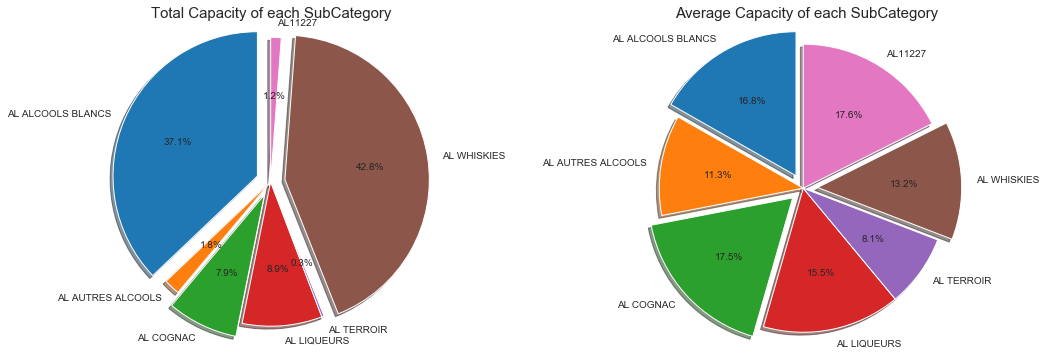

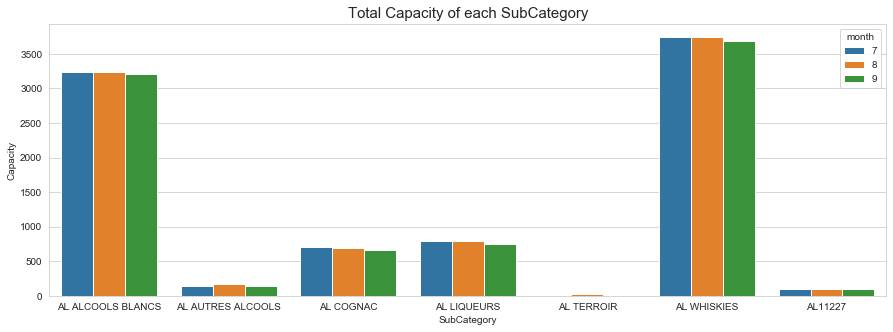

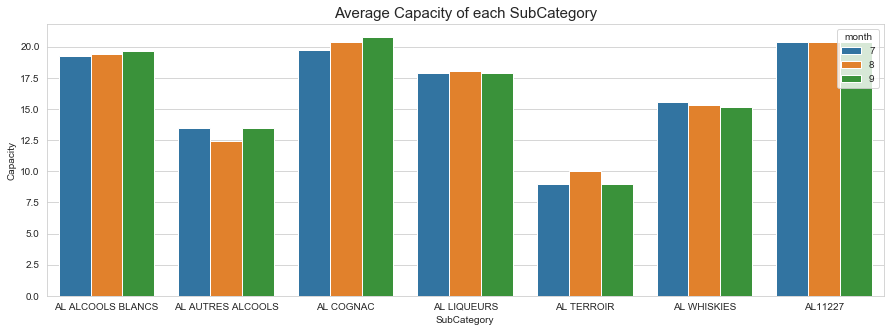


------------------------------------------------------------------
Plot for Facings


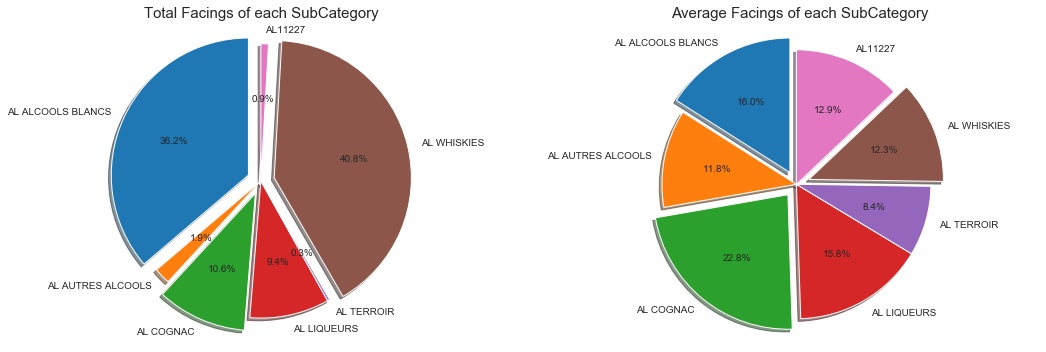

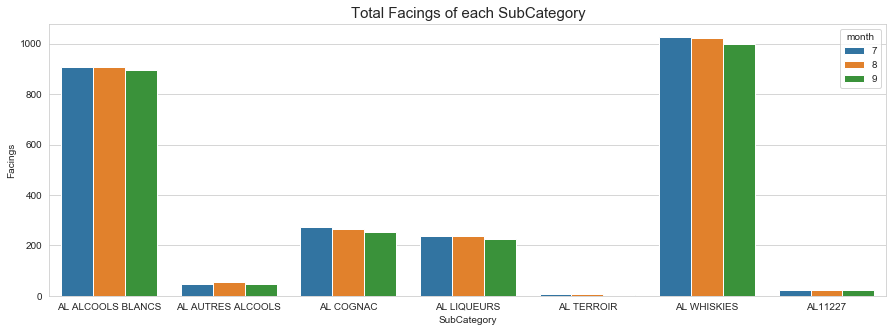

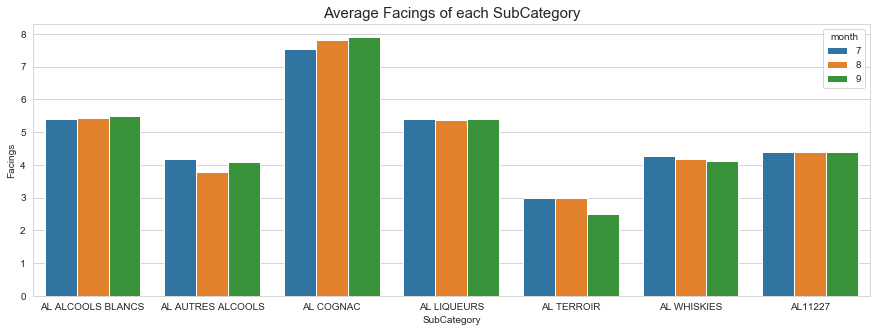


------------------------------------------------------------------


In [8]:
explain_average_and_total_difference()
pie_chart_classification("totalMonthlyQtySold", pdf, 'Total QtySold of each SubCategory', 
                         'Average QtySold of each SubCategory', 
                         explode = (0.1, 0, 0.1, 0, 0, 0.1,0), calss_choice='SubCategory')
pie_chart_classification("Capacity", pdf, 'Total Capacity of each SubCategory', 
                         'Average Capacity of each SubCategory',
                         explode = (0.1, 0, 0.1, 0, 0, 0.1, 0), calss_choice='SubCategory')
pie_chart_classification("Facings", pdf, 'Total Facings of each SubCategory', 
                         'Average Facings of each SubCategory',
                         explode = (0.1, 0, 0.1, 0, 0, 0.1,0), calss_choice='SubCategory')

## Rule 1: Identify low qty sold & high facing items 


Report items which (Rule 1):
- facing is more than monthly sold qty: for example, monthly sold qty is 1, but facing is 2.

## Rule 2: Identify low qty sold & high Capacity items 


Report items which (Rule 1):
- capacity is more than monthly total sold qty: for example, monthly sold qty is 1, but capacity is 2.

There are 544 DISTINCT items totally within this dataset
DISTINCT means DISTINCT SKU
The Example below has "2" distinct items
SKU1 | month1| xxx
SKU1 | month2| xxx
SKU2 | month1| xxx

There are 312 DISTINCT items satisfy this condition


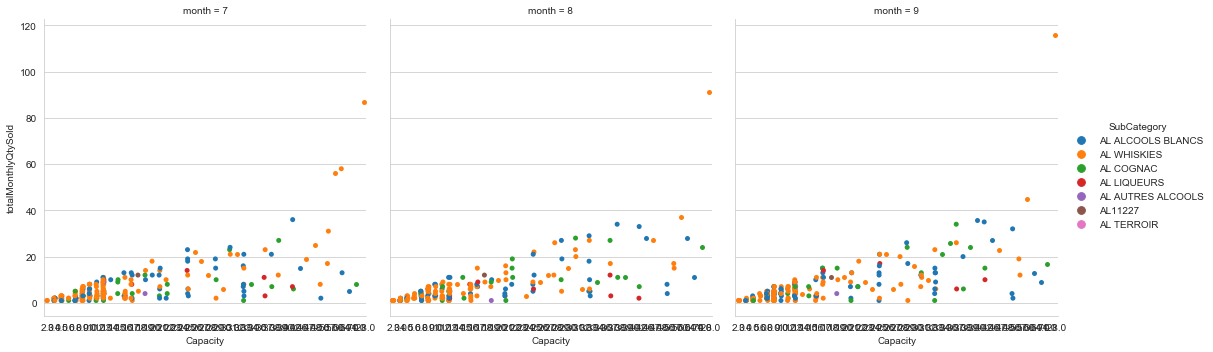

There are 108 DISTINCT items satisfy this condition in three month


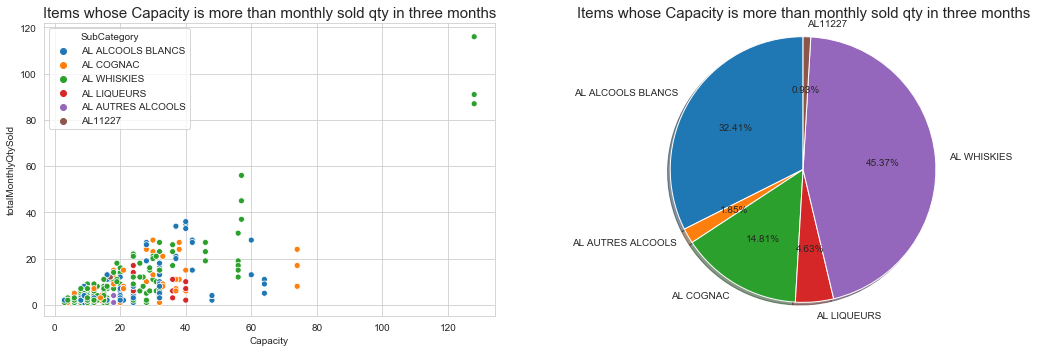

In [9]:
qty_less_than_capacity, full_month_items = find_monthly_qty_less_items(df, 'Capacity',1, "SubCategory")

In [10]:
qty_less_than_capacity.select('SKU', 'SubCategory', "Facings",'Capacity','Classification', 
                            "totalMonthlyQtySold", 'month').show(3)

+--------------------+-----------------+-------+--------+--------------+-------------------+-----+
|                 SKU|      SubCategory|Facings|Capacity|Classification|totalMonthlyQtySold|month|
+--------------------+-----------------+-------+--------+--------------+-------------------+-----+
|ABSOLUT ELYX FLAR...|AL ALCOOLS BLANCS|    8.0|    32.0|             C|               29.0|    8|
|CIROC PINEAPPLE 1...|AL ALCOOLS BLANCS|    5.0|    20.0|             B|               13.0|    9|
|GREY GOOSE 175CL 40%|AL ALCOOLS BLANCS|    5.0|    20.0|             C|                6.0|    7|
+--------------------+-----------------+-------+--------+--------------+-------------------+-----+
only showing top 3 rows



## Rule 3 :
Capacity > monthly total sold qty *3

There are 544 DISTINCT items totally within this dataset
DISTINCT means DISTINCT SKU
The Example below has "2" distinct items
SKU1 | month1| xxx
SKU1 | month2| xxx
SKU2 | month1| xxx

There are 126 DISTINCT items satisfy this condition


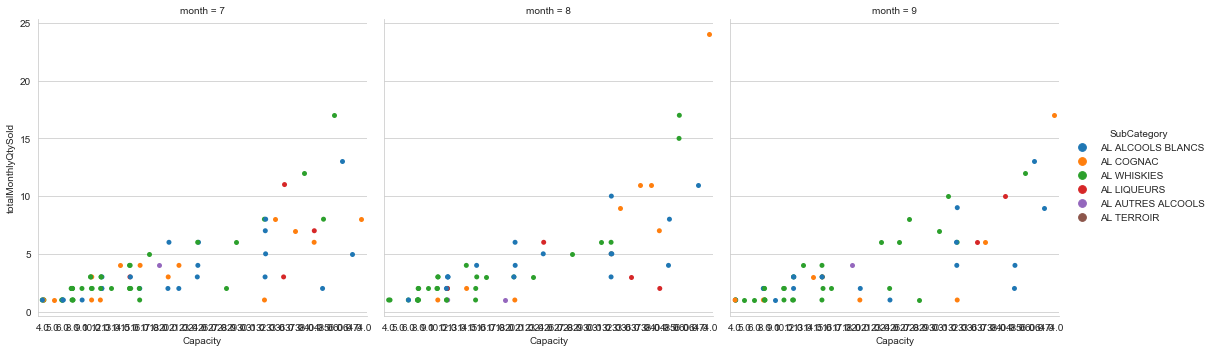

There are 23 DISTINCT items satisfy this condition in three month


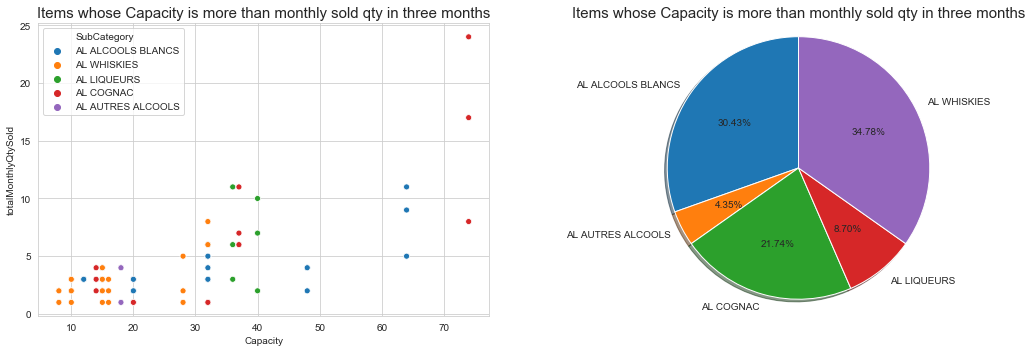

In [11]:
qty_less_than_capacity3, full_month_items_capacity3 = find_monthly_qty_less_items(df, 'Capacity', 3,"SubCategory")

### more plots in the bottom for the items in all 3 months 

## add more analysis columns

In [12]:
# add mean, std and geometric mean of qty sold GROUPBY subcategory and month to datatset 
df = calculate_mean_std_and_geometric_mean(df)
# add capacity/sale ratio to dataset
df = calculate_Capacity_to_sales(df)

# Separte to four group
- Group 1: (monthly total sold qty *2) > capacity > (monthly total sold qty *1)
- Group 2: (monthly total sold qty *3) > capacity > (monthly total sold qty *2)
- Group 3: (monthly total sold qty *4) > capacity > (monthly total sold qty *3)
- Group 4: capacity > (monthly total sold qty *4)

### Separate Group by Capacity

There are 56 DISTINCT items under lowerbound 3, upperbound 4
There are 98 DISTINCT items under lowerbound 2, upperbound 3
There are 211 DISTINCT items under lowerbound 1, upperbound 2

🚩 Group 1: 
(monthly total sold qty *2) > Capacity>= (monthly total sold qty *1)


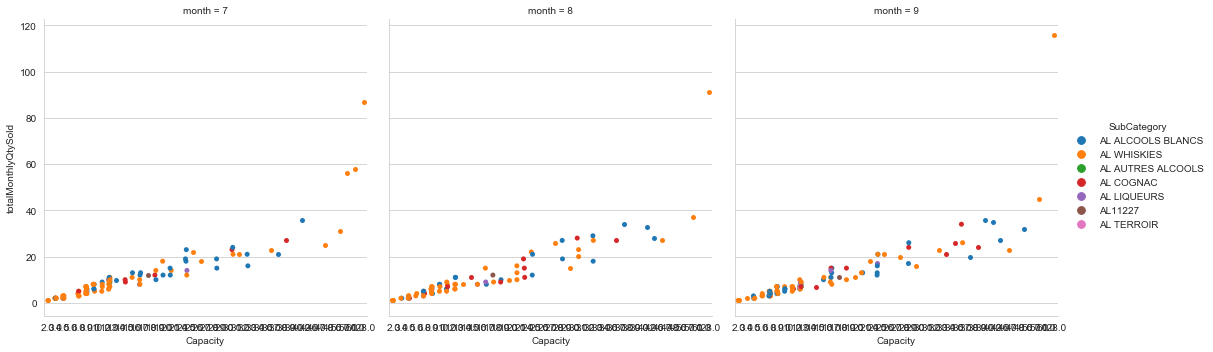

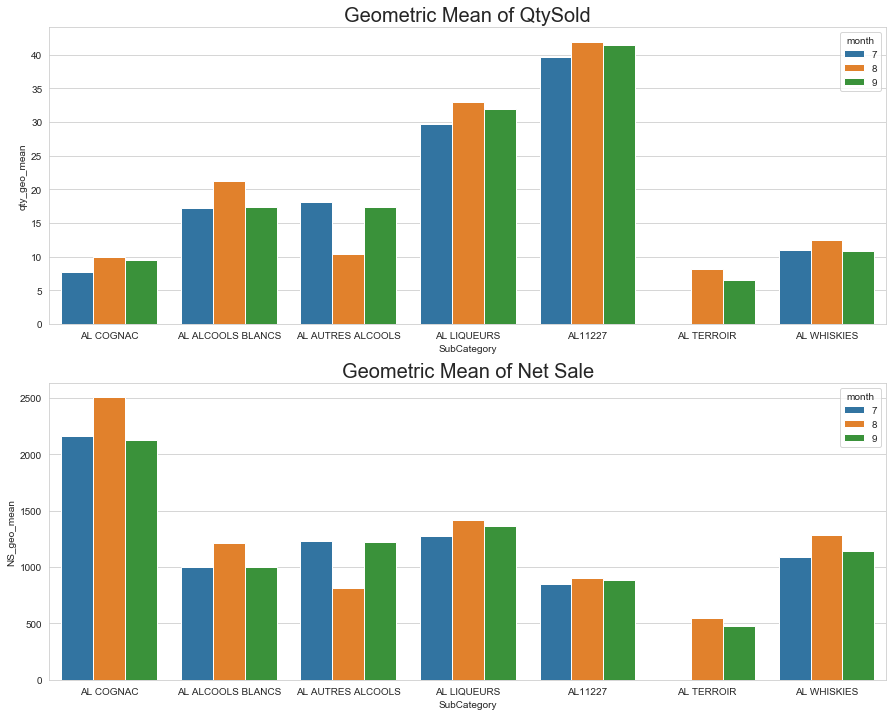


Details for other columns


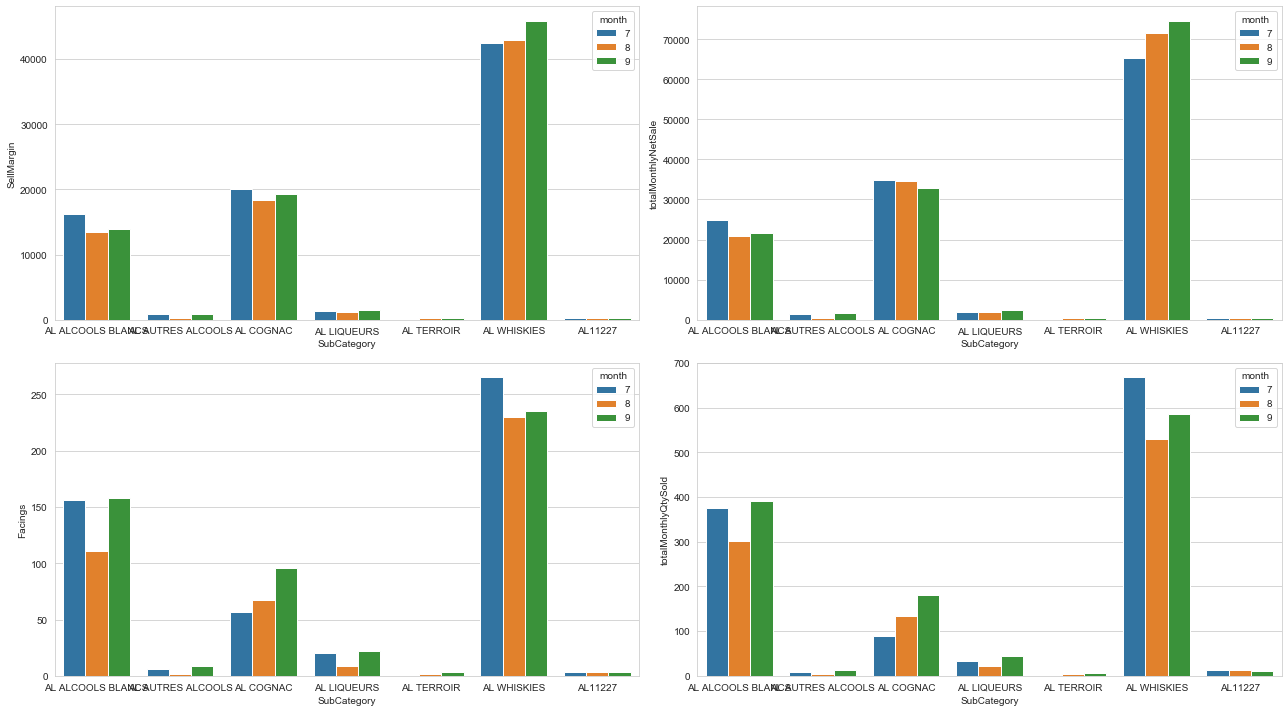


🚩 Group 2: 
(monthly total sold qty *3) > Capacity>= (monthly total sold qty *2)


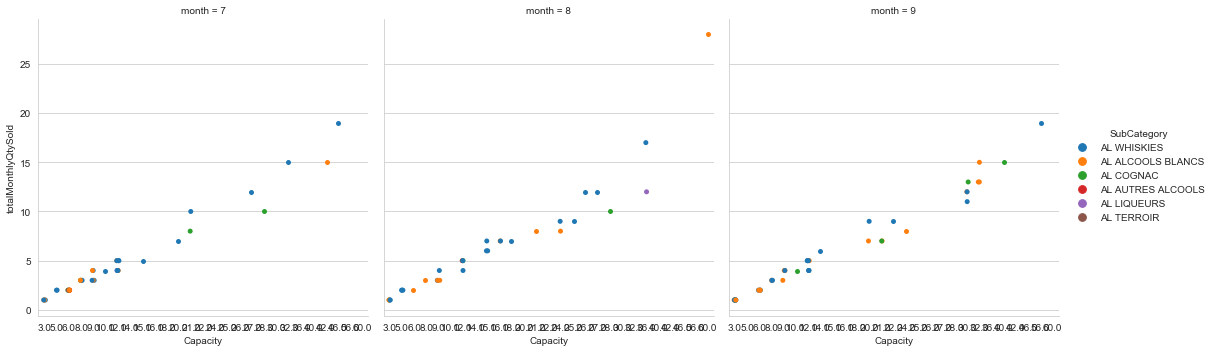

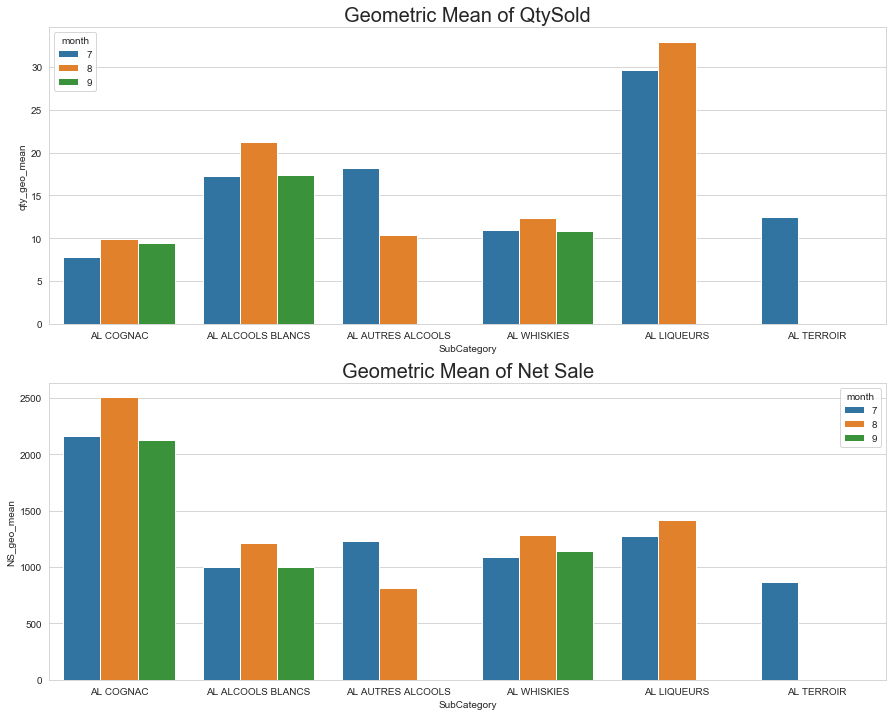


Details for other columns


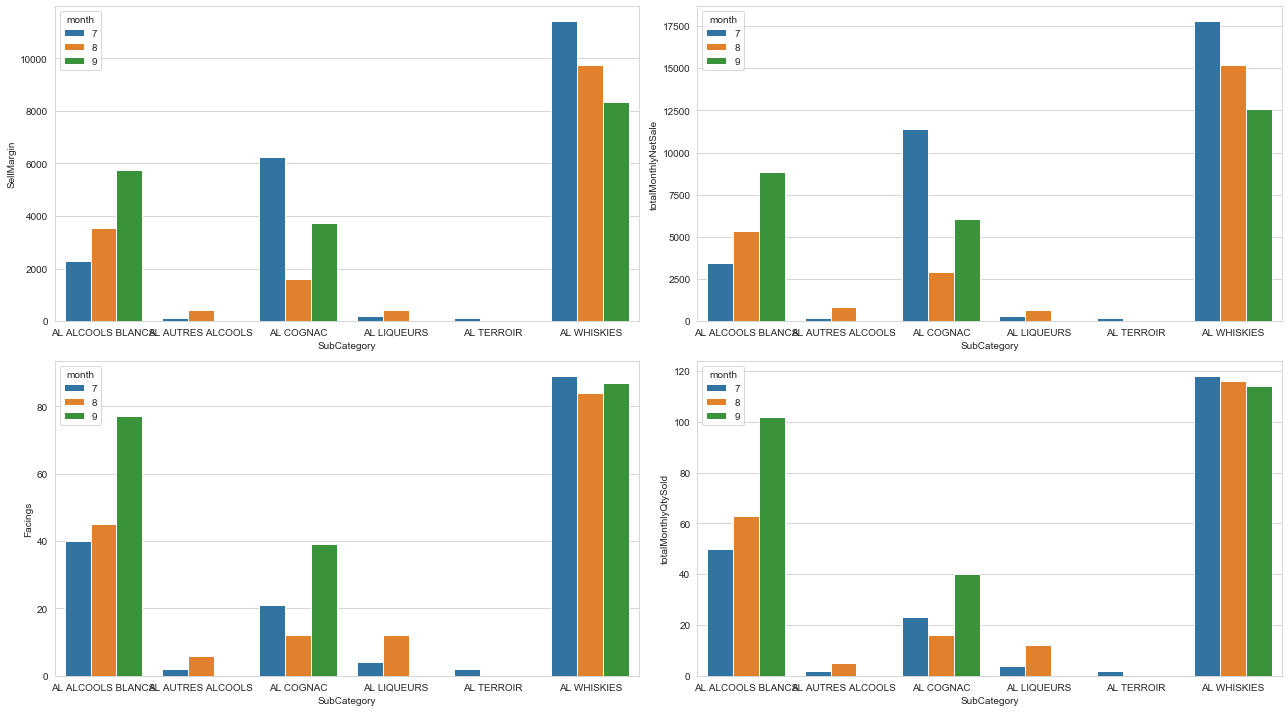


🚩 Group 3: 
(monthly total sold qty *4) > Capacity>= (monthly total sold qty *3)


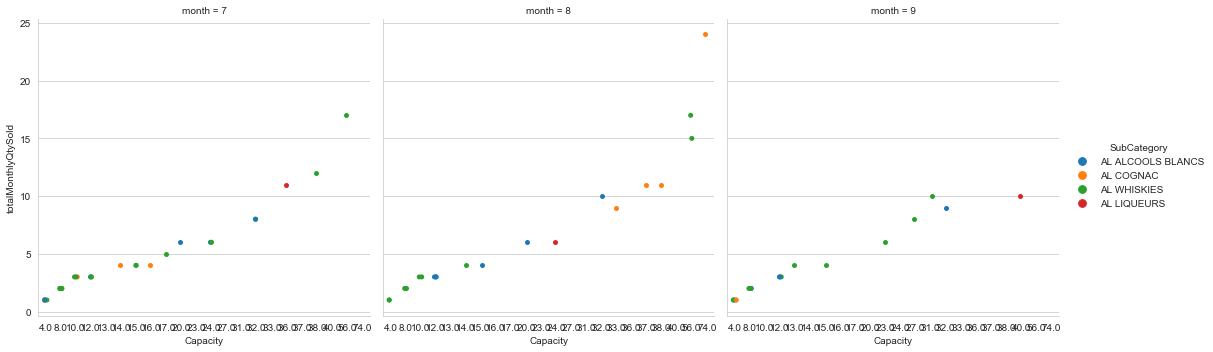

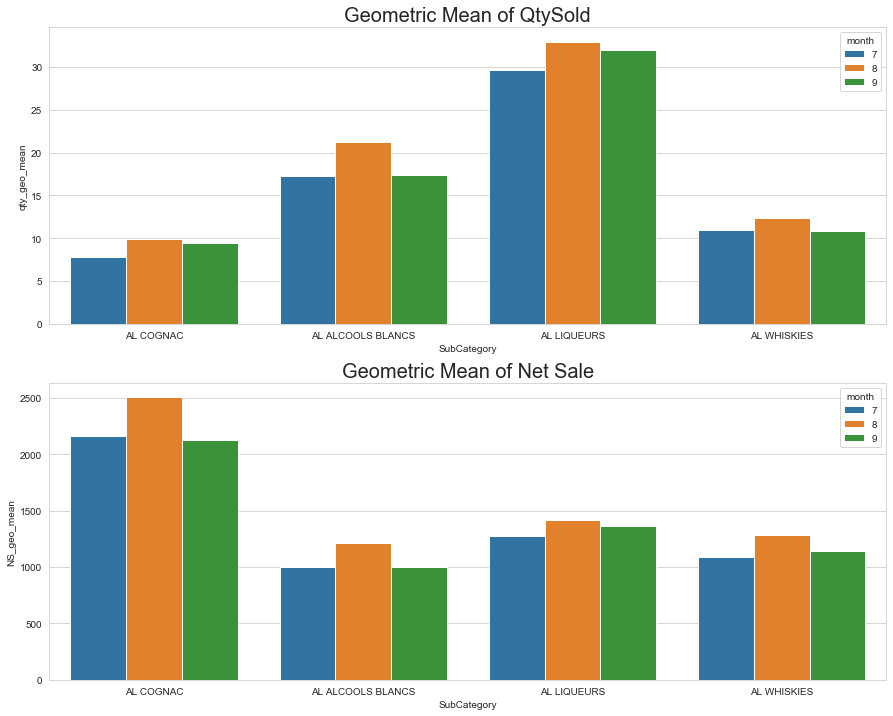


Details for other columns


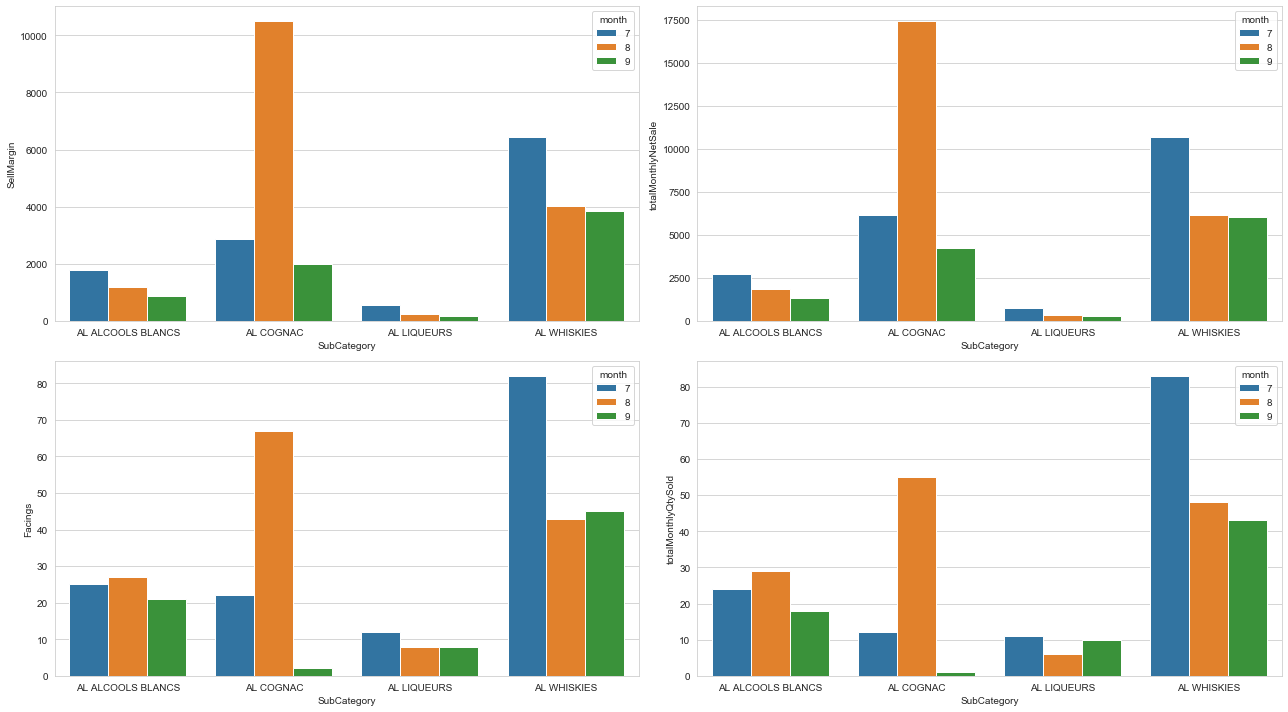


🚩 Group 4: 
Capacity> (monthly total sold qty *4)


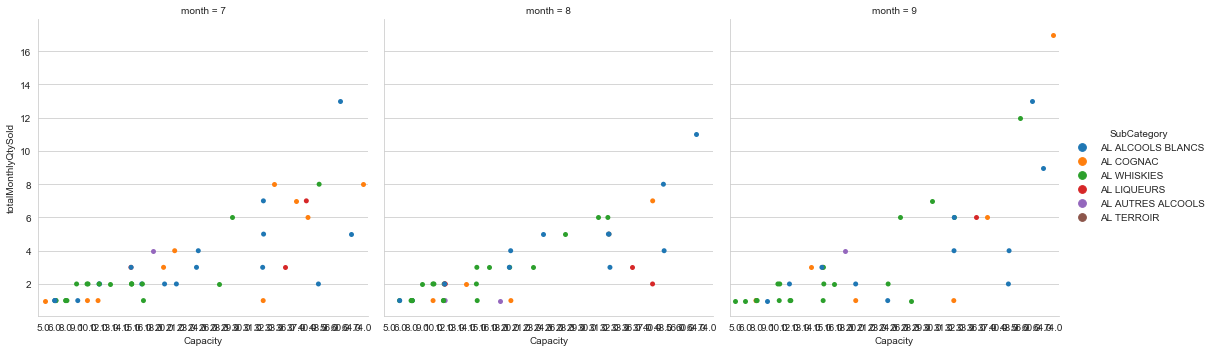

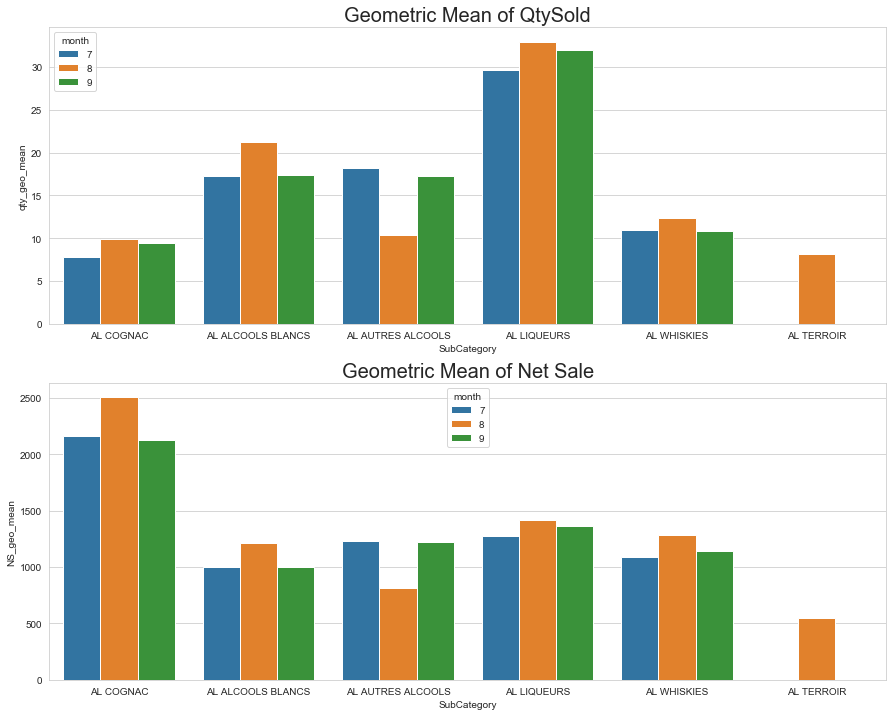


Details for other columns


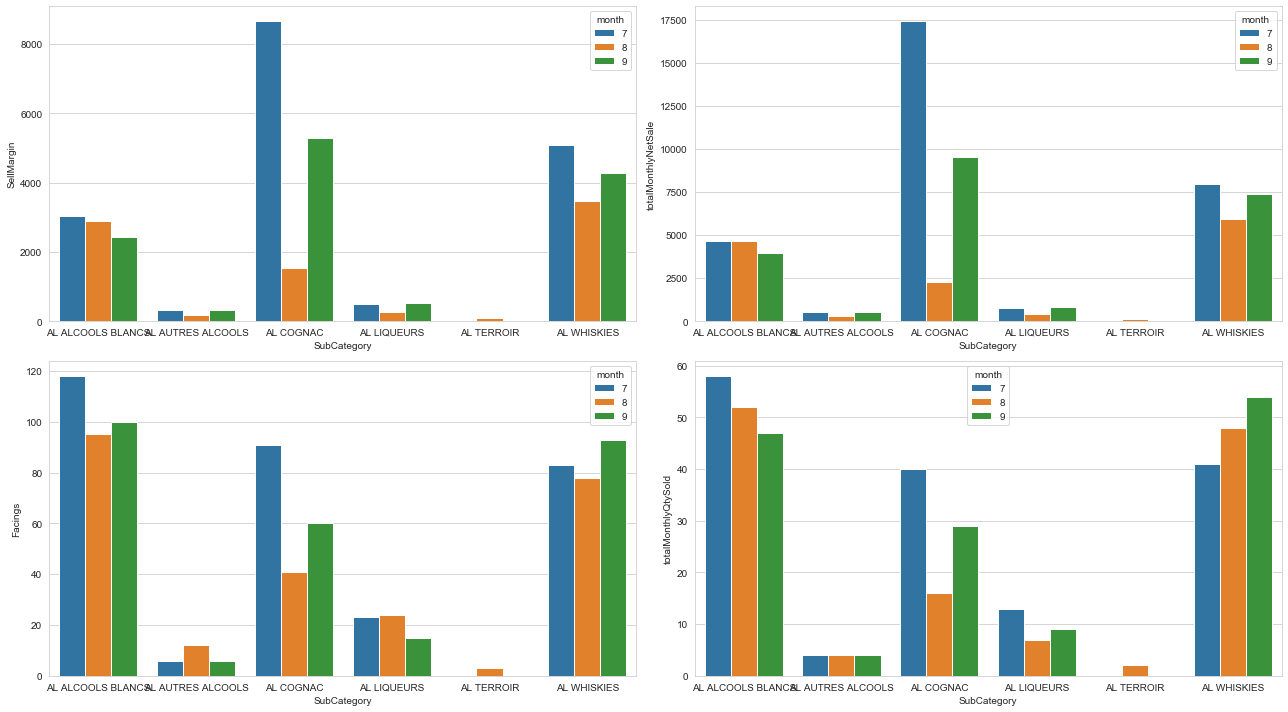

In [13]:
df1, df2, df3, df4 = find_monthly_qty_less_items_4_group(df, 'Capacity', "SubCategory")

### Output 4 groups data to csv file

In [14]:
Groups_output = df1.union(df2).union(df3).union(df4).dropDuplicates().drop('avgCOGS','DaysSupply','avgFrontMargin')
# reorder the columns 
Groups_output = Groups_output.select('SKU', 'MatID', 'month', 'SubCategory', 'Classification','Facings', 'Capacity',
                                    'totalMonthlyNetSale', 'totalMonthlyGrossSale',
                                    'totalMonthlyQtySold', 'Price', 'SellMargin',
                                    'Qty_GeoMean_by_month_Subcat', 'NS_GeoMean_by_month_Subcat',
                                    'Qty_mean_by_month_Subcat', 'NS_mean_by_month_Subcat',
                                    'Qty_std_by_month_Subcat', 'NS_std_by_month_Subcat', 'Capacity_to_qty',
                                    'Capacity_to_sales')
    
Groups_output.toPandas().to_csv('../data/Output/4Groups_qty_less_than_capacity_SKU.csv', 
                             index=False, encoding='utf-8')

### Out put items which Capacity > monthly Qty Sold in all three months

In [15]:
full_month_SKU_info = get_full_month_SKU_info(full_month_items, Groups_output, spark)
full_month_SKU_info.toPandas().to_csv('../data/Output/qty_less_than_capacity_all_month_SKU.csv', 
                             index=False, encoding='utf-8')

full_month_capacity3_SKU_info = get_full_month_SKU_info(full_month_items_capacity3, Groups_output, spark)
full_month_capacity3_SKU_info.toPandas().to_csv('../data/Output/qty_less_than_3timesCapacity_all_month_SKU.csv', 
                             index=False, encoding='utf-8')

In [16]:
pdf_full_month = full_month_SKU_info.toPandas()

full_month_capacity3_SKU = full_month_capacity3_SKU_info.toPandas()

### More details of items whose capacity > monthly sold Qty in three month

There are 108 DISTINCT items
  Classification  totalMonthlyNetSale
0              A         339071.53125
1             A+          57207.75000
2              B         278830.75000
3              C         382438.06250

⭐️Sell Margin % means: SumSellMarginselected items / SumSellMargin of all items within classifiction 


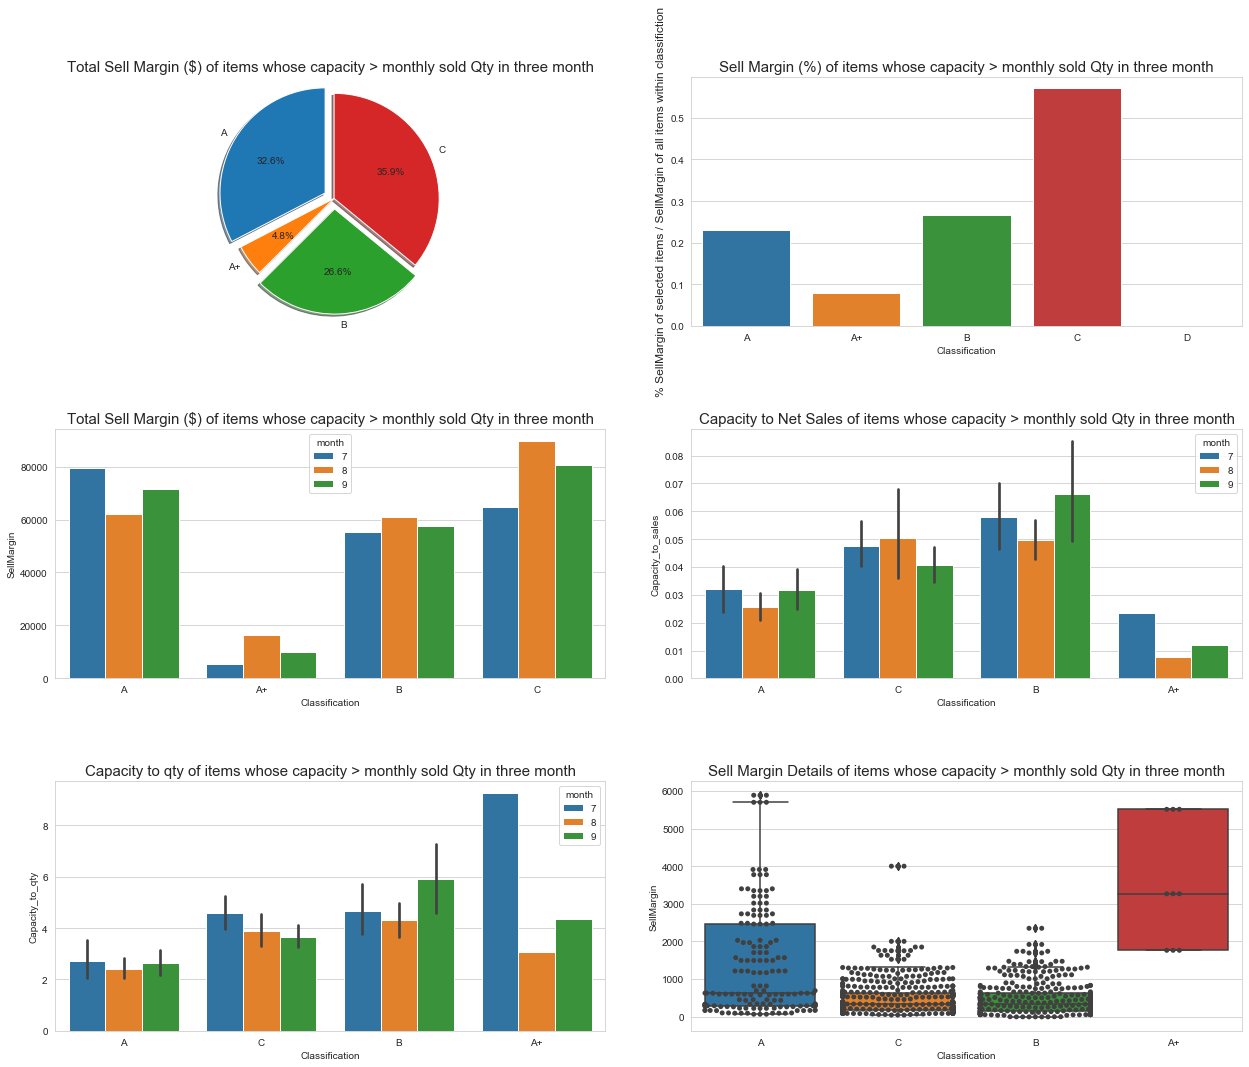

In [17]:
pie_chart_margin_selectedItem("SellMargin", pdf, pdf_full_month, 'Total Sell Margin ($) of items whose capacity > monthly sold Qty in three month', 
                         'Sell Margin (%) of items whose capacity > monthly sold Qty in three month', 
                         explode = (0.1, 0, 0.1, 0))

There are 23 DISTINCT items
  Classification  totalMonthlyNetSale
0              A          3223.199951
1             A+         57207.750000
2              B         37651.289062
3              C         49058.250000

⭐️Sell Margin % means: SumSellMarginselected items / SumSellMargin of all items within classifiction 


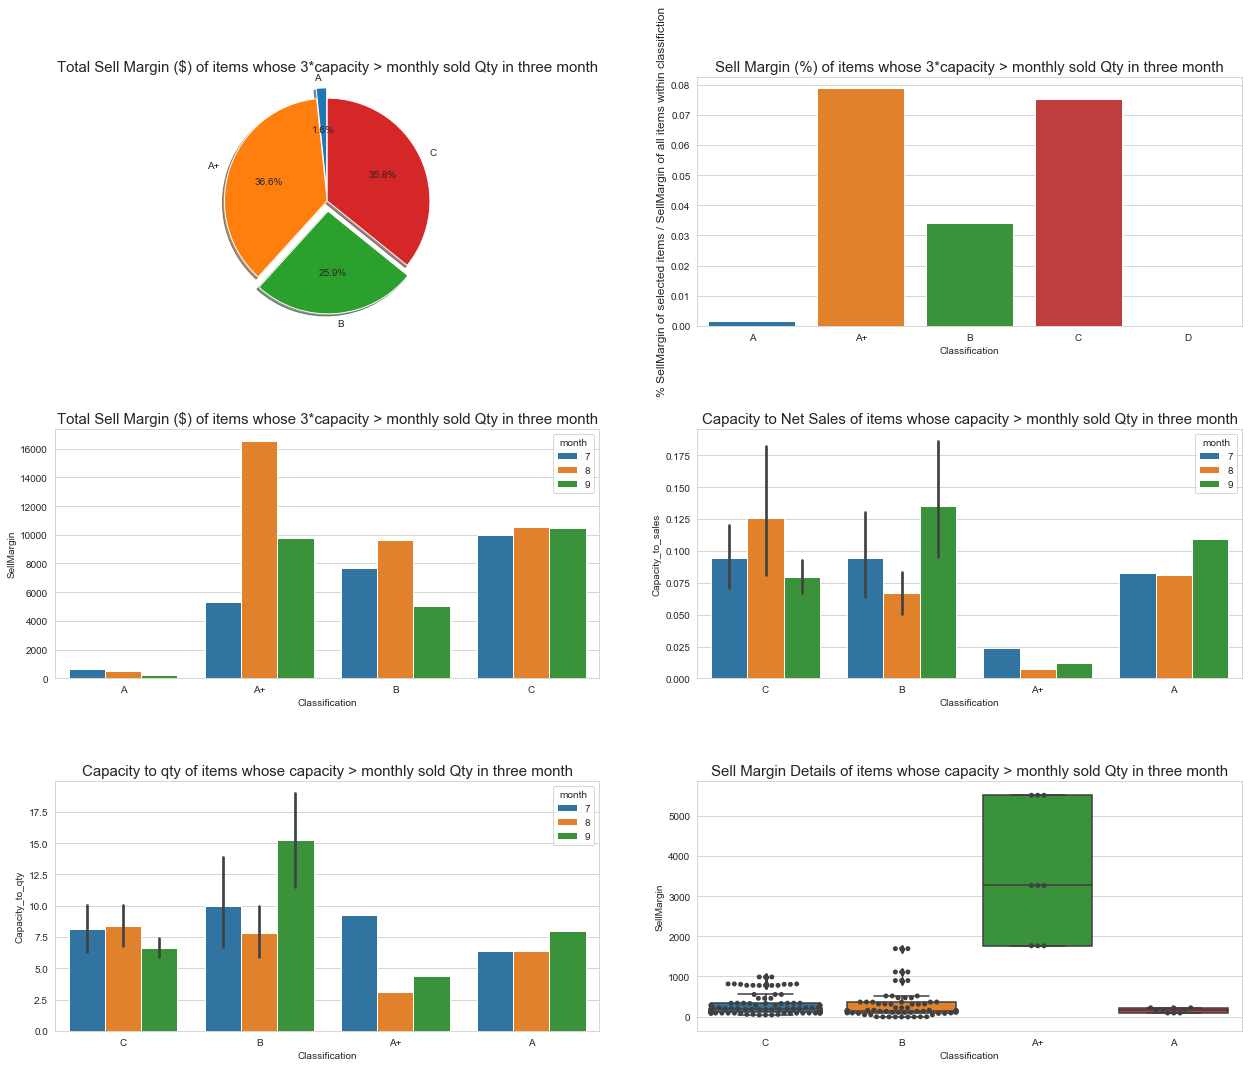

In [18]:
pie_chart_margin_selectedItem("SellMargin", pdf, full_month_capacity3_SKU, 'Total Sell Margin ($) of items whose 3*capacity > monthly sold Qty in three month', 
                         'Sell Margin (%) of items whose 3*capacity > monthly sold Qty in three month', 
                         explode = (0.1, 0, 0.1, 0))